Epoch [1/25] | Train Loss: 0.517611 | Val Loss: 0.272606
Epoch [2/25] | Train Loss: 0.229054 | Val Loss: 0.201889
Epoch [3/25] | Train Loss: 0.174664 | Val Loss: 0.170180
Epoch [4/25] | Train Loss: 0.142306 | Val Loss: 0.150789
Epoch [5/25] | Train Loss: 0.119104 | Val Loss: 0.131599
Epoch [6/25] | Train Loss: 0.101763 | Val Loss: 0.122844
Epoch [7/25] | Train Loss: 0.088445 | Val Loss: 0.110709
Epoch [8/25] | Train Loss: 0.077715 | Val Loss: 0.106998
Epoch [9/25] | Train Loss: 0.069986 | Val Loss: 0.101949
Epoch [10/25] | Train Loss: 0.062688 | Val Loss: 0.096764
Epoch [11/25] | Train Loss: 0.055505 | Val Loss: 0.094780
Epoch [12/25] | Train Loss: 0.050795 | Val Loss: 0.092642
Epoch [13/25] | Train Loss: 0.045596 | Val Loss: 0.090581
Epoch [14/25] | Train Loss: 0.041793 | Val Loss: 0.090360
Epoch [15/25] | Train Loss: 0.038663 | Val Loss: 0.088894
Epoch [16/25] | Train Loss: 0.035216 | Val Loss: 0.088170
Epoch [17/25] | Train Loss: 0.031130 | Val Loss: 0.086905
Epoch [18/25] | Train L

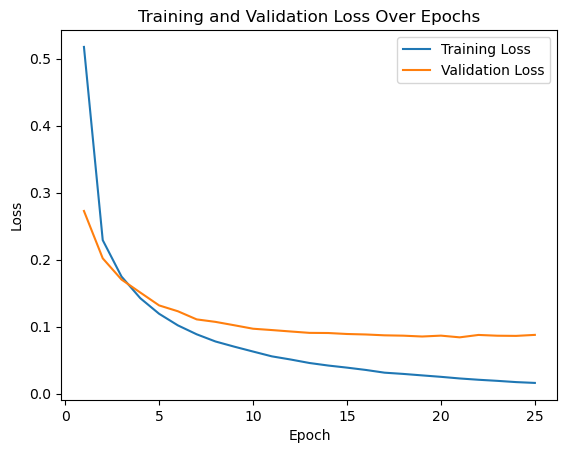

Test Accuracy: 98.01%


<Figure size 640x480 with 0 Axes>

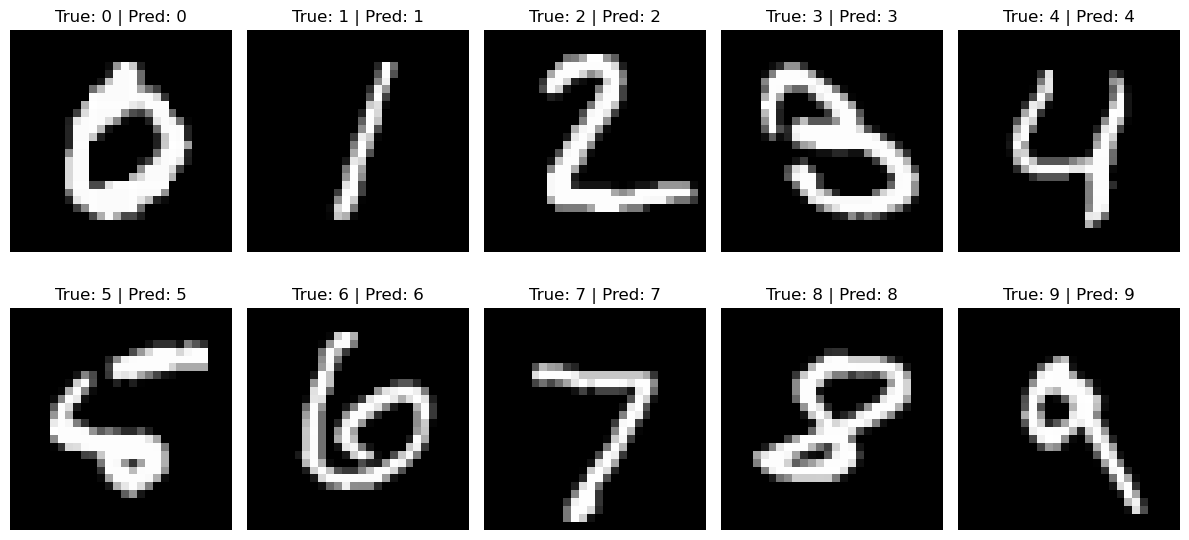

In [1]:
#!/usr/bin/env python3

import matplotlib
matplotlib.use('TkAgg')
import numpy as np
import struct
from array import array
from os.path import join
import random
import matplotlib.pyplot as plt

# Import MLP components from your mlp.py module.
from mlp import Layer, MultilayerPerceptron, CrossEntropy, Relu, Softmax, plot_losses



###############################################################################
# MNIST Data Loader Class
###############################################################################
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols], dtype=np.float32)
            img = img.reshape(rows, cols)
            images.append(img)
        return np.array(images), np.array(labels)

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test))


###############################################################################
# Helper function to show a list of images with titles.
###############################################################################
def show_images(images, title_texts):
    cols = 5
    rows = int(np.ceil(len(images) / cols))
    plt.figure(figsize=(12, 3 * rows))
    for idx, (img, title_text) in enumerate(zip(images, title_texts), 1):
        plt.subplot(rows, cols, idx)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(title_text, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


###############################################################################
# Helper function to convert labels to one-hot encoding.
###############################################################################
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels.astype(int)]


###############################################################################
# Main training function for MNIST classification using MLP.
###############################################################################
def main():
    # Set file paths (adjust these paths to where you have the MNIST idx files)
    input_path = '/Users/mubaraqolojo/Downloads/MLP/archive'  # <-- change as needed
    training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
    training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
    test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
    test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

    # Load the data using the MNIST dataloader.
    mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath,
                                       test_images_filepath, test_labels_filepath)
    (x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

    # Normalize and flatten images: scale pixel values to [0, 1] and flatten to vectors of length 784.
    x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
    x_test  = x_test.reshape(x_test.shape[0], -1) / 255.0

    # Split x_train into training and validation sets (80% train, 20% validation).
    n_samples = x_train.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    split = int(0.8 * n_samples)
    train_indices, val_indices = indices[:split], indices[split:]
    train_x, train_y = x_train[train_indices], y_train[train_indices]
    val_x, val_y = x_train[val_indices], y_train[val_indices]

    # One-hot encode labels for training and validation.
    train_y_oh = one_hot_encode(train_y)
    val_y_oh   = one_hot_encode(val_y)

    # Build the MLP for classification.
    # Architecture: 784 -> 128 (ReLU) -> Dropout -> 64 (ReLU) -> Dropout -> 10 (Softmax)
    layers = [
        Layer(fan_in=784, fan_out=512, activation_function=Relu(),
        dropout_rate = 0.05),
        Layer(fan_in=512, fan_out=128, activation_function=Relu(),
        dropout_rate=0.01),
        Layer(fan_in=128, fan_out=10, activation_function=Softmax())
    ]
    mlp = MultilayerPerceptron(layers)
    loss_func = CrossEntropy()

    # Training parameters.
    learning_rate = 1e-4
    batch_size = 64
    epochs =25

    # Train the network.
    train_losses, val_losses = mlp.train(
        train_x, train_y_oh,
        val_x, val_y_oh,
        loss_func=loss_func,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        rmsprop=True
    )
    %matplotlib inline
    # Plot loss curves.
    plot_losses(train_losses, val_losses)

    # Evaluate on the test set.
    test_pred = mlp.forward(x_test, training=False)
    predicted_classes = np.argmax(test_pred, axis=1)
    accuracy = np.mean(predicted_classes == y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Display one sample per class (0–9).
    selected_images = []
    selected_titles = []
    for digit in range(10):
        idx = np.where(y_test == digit)[0][0]
        img = x_test[idx].reshape(28, 28) * 255
        pred = predicted_classes[idx]
        selected_images.append(img)
        selected_titles.append(f"True: {digit} | Pred: {pred}")
    show_images(selected_images, selected_titles)

if __name__ == '__main__':
    main()
